In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon, LineString
from shapely import wkt

from datasets import get_retail_store_minnesota
from utilis import *

from matplotlib import pyplot as plt
plt.style.use('seaborn-poster')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# **Traveling Salesman Problem**

>"Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?".


Travelling Salesman Problem (TSP) aims to find the optimal solution which has the minimal sum of visiting distances and contains only a single tour covering all cities. TSP is a NP-hard problem in Optimization study (specifically in Combinatorial Optimization). And the solutions of TSP have been commonly applied to Vehicle Routing ("What is the optimal set of routes for a fleet of vehicles to traverse in order to deliver to a given set of customers?) and other spatial analytics usecases. 

## **Definition of TSP**

Given Graph $G(V, E)$
- No self-loop in $G$
- $V$: the set of all cities ($i$=1 ... N )
- $E$: the set of roads between cities
- $c_{ij}$: the distance between city $i$ and city $j$
- $\begin{equation}
  x_{ij}=\left\{
  \begin{array}{@{}ll@{}}
    1, & \text{if}\ the\ solution\ travels\ from\ city\ i\  to\ city\ j\\
    0, & \text{otherwise}
  \end{array}\right.
\end{equation} $
-  $u$:   $u_i$ = $t$,  if city i is visited in step t (i, t = 1, 2, ..., n)


**Target**

$$min\sum_{i=1}^{N}\sum_{j\neq i, j=1}^{N}c_{ij}x_{ij}\\
s.t.\\
\sum_{i=1}^{N}x_{ij}=1 \quad \forall j\in V   \\
\sum_{j=1}^{N}x_{ij}=1 \quad \forall i\in V  \\
u_{i} \in \mathbb{Z}\quad i=1 ... N \\
u_i - u_j + Nx_{ij} \leq N-1 \quad \forall\ i,\ j\in V,\ i\neq j,\ i\neq 1,\ j\neq 1\\
\forall u_{j} \geq 0\\
\forall x_{ij} =0\ or\ 1$$


The restrictions make sure each city is arrived at from exactly one other city and from each city there is a departure to exactly one other city. Also they enforce that there is only a single tour covering all cities, and not two or more disjointed tours that only collectively cover all cities 

## **Algorithms**

In general, there are two types of algorithms to address TSP:
- Exact Algorithms
    - Brute Force $O(n!)$
    - Dynamic Programming $O(n^22^n)$
    - ...
- Approximation Algorithms
    - Christofides Algorithm
    - Simulated Annealing
    - Ant Colony Optimizatiom
    - ...
    
Generally speaking, exact algorithms can reach the best solution but take longer than expected runtime. Considering the time constraint, approximation algorithms are more commonly used even though the solution is not gloabl optimal. The following example shows how to solve TSP. 


## **Example**

We have the location of each Target stores (or any other retailer) in US. Suppose a manager wants to inspect all 73 store in Minnesota, the company's home state, what's the best route with the shortest distance? 


### **Data**

In [2]:
data = get_retail_store_minnesota()
data['store_id'] = data['store_id'].apply(lambda x: str(int(x)))

In [3]:
# lat/lng pairs (e.g.[[47.209549, -93.527193], ...])
latlng = [[store.y, store.x] for store in data['the_geom']]
# lng/lat pairs (e.g.[[-93.527193, 47.209549], ...])
lnglat = [[store.x, store.y] for store in data['the_geom']]

# id: lat/lng dictionary (e.g.{'100': [47.209549, -93.527193], ...})
latlng_dict = {store[1]['store_id']: [store[1]['the_geom'].y, store[1]['the_geom'].x] for store in data.iterrows()}
# id: lng/lat dictionary (e.g.{'100': [-93.527193, 47.209549], ...})
lnglat_dict = {store[1]['store_id']: [store[1]['the_geom'].x, store[1]['the_geom'].y] for store in data.iterrows()}

In [4]:
from cartoframes.viz import Layer, basic_style, color_category_legend, formula_widget

Layer(data, 
      basic_style(size = 10), 
      legends=color_category_legend(title = 'Retail Store Locations'),
      widgets=[formula_widget('count', 
                              title='Number of Retail Stores', 
                              description='Minnesota')]
     )

### Method 1: **Christofides Method**


```markdown
1. Create a minimum spanning tree T of G.
2. Let O be the set of vertices with odd degree in T. 
3. Find a minimum-weight perfect matching M in the induced subgraph given by the vertices from O.
4. Combine the edges of M and T to form a connected multigraph H in which each vertex has even degree.
5. Form an Eulerian circuit in H.
6. Make the circuit found in previous step into a Hamiltonian circuit by skipping repeated vertices (shortcutting).
```

<br/>

**Run `n=100` iterations of Christofides Method, then find the shortest path**, 

The length of the shortest path: 2075557.7428288625 m


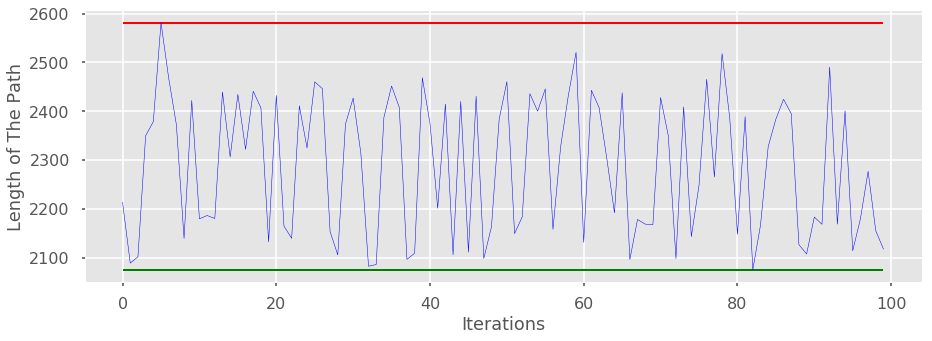

In [5]:
n = 100
tests = [christofides(latlng) for _ in range(n)]
length = [_[6] for _ in tests]  

# the following plot shows length of path of each iteration run. 
f, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(length, color='blue', linewidth=0.5)
ax.hlines(y=min(length), xmin=0, xmax=n-1, color='green', linewidth=2)
ax.hlines(y=max(length), xmin=0, xmax=n-1, color='red', linewidth=2)
ax.set_xlabel('Iterations')
ax.set_ylabel('Length of The Path')

tsp_result = tests[np.argmin(length)]
print(f'The length of the shortest path: {min(length)*1000} m')

<br/>

**The Following part shows how christofides algorithm works step by step**

#### 1. **Complete Graph (G)**

In [6]:
from cartoframes.viz import Map

complete_graph = pd.DataFrame([LineString(store) for store in combinations(lnglat, 2)], columns=['geometry'])
map1 = Map(Layer(complete_graph,
             geom_col = 'geometry',
             style = basic_style(size = 0.2, color = 'red', opacity = 0.3), 
             legends=color_category_legend(title = 'Step 1: Complete Graph'),
             widgets=[formula_widget('count', 
                              title='Number of Edges', 
                              description='in Complete Graph (G)')]
     ))
map1

#### 2. **Minimum Spanning Tree (T)**

In [7]:
minimum_spanning_tree = pd.DataFrame([LineString([lnglat[store1_id], lnglat[store2_id]]) for store1_id, store2_id, _ in tsp_result[1]], columns=['geometry'])
map2 = Map(layers=[
    Layer(complete_graph,
          geom_col = 'geometry',
          style = basic_style(size = 0.5, color = 'red', opacity = 0.1), 
          widgets = [formula_widget('count', 
                                    title='Number of Edges', 
                                    description='in Complete Graph (G)')]),
    Layer(minimum_spanning_tree,
          geom_col = 'geometry',
          style = basic_style(size = 3), 
          legends = color_category_legend(title = 'Step 2: Minimum Spanning Tree (T)'),
          widgets = [formula_widget('count', 
                                    title='Number of Edges', 
                                    description='in Minimum Spanning Tree (T)')])],
    basemap = basemaps.voyager)
map2

#### 3. **Vertices with odd degree (O)**

In [8]:
vertices_odd_degree = pd.DataFrame([Point(*lnglat[store_id]) for store_id in tsp_result[2]], columns=['geometry'])
map3 = Map(layers=[
    Layer(complete_graph,
          geom_col = 'geometry',
          style = basic_style(size = 0.2, color = 'red', opacity = 0.1)), 
    Layer(minimum_spanning_tree,
          geom_col = 'geometry',
          style = basic_style(size = 3)), 
    Layer(vertices_odd_degree,
          geom_col = 'geometry',
          style = basic_style(size = 3, color = 'yellow'),
          legends = color_category_legend(title = 'Step 3: Vertices with odd degree (O)'),
          widgets = [formula_widget('count', title='Number of Vertices with Odd Degrees (O)', description='in Minimum Spanning Tree (T)')])
    ],
    basemap = basemaps.voyager)
map3

#### 4. **Form the subgraph G' of G using only the vertices of O (G')**

In [9]:
sub_complete_graph = pd.DataFrame([LineString(pair) for pair in combinations([list(lnglat)[i] for i in tsp_result[2]], 2)], columns=['geometry'])
map4 = Map(layers=[
    Layer(sub_complete_graph,
          geom_col = 'geometry',
          style = basic_style(size = 0.8, color = 'red', opacity = 0.2), 
          widgets = [formula_widget('count', title='Number of Edges', description="in subgraph G' using only the vertices of O")]),
    Layer(vertices_odd_degree,
          geom_col = 'geometry',
          style = basic_style(size = 7, color = 'yellow'),
          legends = color_category_legend(title = "Step 4: Form the subgraph G' of G using only the vertices of O (G')"),
          widgets = [formula_widget('count', title='Number of Vertices with Odd Degrees (O)', description='in Minimum Spanning Tree (T)')])
    ],
    basemap = basemaps.voyager)
map4

#### 5. **Minimum-Weight (perfect) matching M From G' (M)**

In [10]:
min_weight_perfect_matching = pd.DataFrame([LineString([lnglat[store1_id], lnglat[store2_id]]) for store1_id, store2_id, _ in tsp_result[3]], columns=['geometry'])
map5 = Map(layers=[
    Layer(sub_complete_graph,
          geom_col = 'geometry',
          style = basic_style(size = 0.7, color = 'red', opacity = 0.2), 
          widgets = [formula_widget('count', title='Number of Edges', description="in subgraph G' using only the vertices of O", is_global=True)]),
    Layer(minimum_spanning_tree,
          geom_col = 'geometry',
          style = basic_style(size = 3, color = '#46aea0')),
    Layer(min_weight_perfect_matching,
          geom_col = 'geometry',
          style = basic_style(size = 3, color = 'green'),
          legends = color_category_legend(title = "Step 5: Minimum-Weight (perfect) matching M From G' (M)"),
          widgets = [formula_widget('count', title='Number of Edges in M', description="in Minimum-Weight (perfect) matching M From G'", is_global=True)]),
    Layer(vertices_odd_degree,
          geom_col = 'geometry',
          style = basic_style(size = 7, color = 'yellow')),
    ],   
    viewport = {'zoom': 8.21, 'lat': 44.967879, 'lng': -93.365291},
    basemap = basemaps.voyager)
map5

#### 6. **Unite matching and spanning tree T ∪ M to form an Eulerian multigraph (H)**

In [11]:
united_eulerian_multigraph = pd.DataFrame([LineString([lnglat[store1_id], lnglat[store2_id]]) for store1_id, store2_id, _ in tsp_result[4]], columns=['geometry'])
map6 = Map(layers=[
    Layer(sub_complete_graph,
          geom_col = 'geometry',
          style = basic_style(size = 0.3, color = 'red', opacity = 0.2)), 
    Layer(united_eulerian_multigraph,
          geom_col = 'geometry',
          style = basic_style(size = 3, color = 'darkgreen'),
          legends = color_category_legend(title = "Step 6: Unite matching and spanning tree T ∪ M to form an Eulerian multigraph (H)"),
          widgets = [formula_widget('count', title='Number of Edges in H', description="in Eulerian multigraph (H)", is_global=True)]),
    Layer(vertices_odd_degree,
          geom_col = 'geometry',
          style = basic_style(size = 7, color = 'yellow'))],
    basemap = basemaps.voyager)
map6

#### 7. **Euler Tour (E)**

In [12]:
euler_tour = pd.DataFrame([LineString((lnglat[tsp_result[5][i-1]], lnglat[tsp_result[5][i]])) for i in range(1, len(tsp_result[5]))], columns=['geometry'])
euler_tour['order'] = euler_tour.index + 1
euler_tour_origin = pd.DataFrame([Point(lnglat[tsp_result[5][i-1]]) for i in range(1, len(tsp_result[5]))], columns=['geometry'])
euler_tour_origin['order'] = euler_tour_origin.index + 1
euler_tour_dst = pd.DataFrame([Point(lnglat[tsp_result[5][i]]) for i in range(1, len(tsp_result[5]))], columns=['geometry'])
euler_tour_dst['order'] = euler_tour_dst.index + 1

map7 = Map(layers=[
    Layer(sub_complete_graph, 
          geom_col = 'geometry',
          style = basic_style(size = 0.3, color = 'red', opacity = 0.1)), 
    Layer(united_eulerian_multigraph, 
          geom_col = 'geometry',
          style = basic_style(size = 3, color = 'darkgreen', opacity = 0.1)),
    Layer(minimum_spanning_tree, 
          geom_col = 'geometry',
          style = basic_style(size = 3, color = '#46aea0', opacity = 0.1)),
    Layer(euler_tour, 
          geom_col = 'geometry',
          style = animation_style('order', size = 3, color = 'orange', opacity = 0.8, duration=40, fade_in = 0, fade_out = 'hold'),
          legends = color_category_legend(title = "Step 7: Euler Tour (E)")),
    Layer(euler_tour_origin, 
          geom_col = 'geometry',
          style = animation_style('order', size = 8, color = '#882255', opacity = 1, duration=40, fade_in = 0, fade_out = 0.5)),
    Layer(euler_tour_dst, 
          geom_col = 'geometry',
          style = animation_style('order', size = 8, color = '#88CCEE', opacity = 1, duration=40, fade_in = 0, fade_out = 0.5)),
    Layer(vertices_odd_degree, 
          geom_col = 'geometry',
          style = basic_style(size = 7, color = 'yellow', opacity = 0.1))
    ],
    basemap = basemaps.voyager)
map7

#### 8. **Shortcutting**

In [13]:
shortcutting = pd.DataFrame([LineString((lnglat[tsp_result[7][i-1]], lnglat[tsp_result[7][i]])) for i in range(1, len(tsp_result[7]))], columns=['geometry'])
shortcutting['order'] = shortcutting.index + 1
shortcutting_origin = pd.DataFrame([Point(lnglat[tsp_result[7][i-1]]) for i in range(1, len(tsp_result[7]))], columns=['geometry'])
shortcutting_origin['order'] = shortcutting_origin.index + 1
shortcutting_dst = pd.DataFrame([Point(lnglat[tsp_result[7][i]]) for i in range(1, len(tsp_result[7]))], columns=['geometry'])
shortcutting_dst['order'] = shortcutting_dst.index + 1

map8 = Map(layers=[
    Layer(vertices_odd_degree, 
          geom_col = 'geometry',
          style = basic_style(size = 7, color = 'yellow', opacity = 0.1)),
    Layer(sub_complete_graph, 
          geom_col = 'geometry',
          style = basic_style(size = 0.3, color = 'red', opacity = 0.1)), 
    Layer(united_eulerian_multigraph, 
          geom_col = 'geometry',
          style = basic_style(size = 3, color = 'darkgreen', opacity = 0.1)),
    Layer(minimum_spanning_tree, 
          geom_col = 'geometry',
          style = basic_style(size = 3, color = '#46aea0', opacity = 0.1)),
    Layer(euler_tour, 
          geom_col = 'geometry',
          style = animation_style('order', size = 1, color = 'orange', opacity = 0.8, duration=40, fade_in = 0, fade_out = 'hold')),
    Layer(shortcutting_origin, 
          geom_col = 'geometry',
          style = animation_style('order', size = 10, color = '#882255', opacity = 1, duration=40, fade_in = 0, fade_out = 0.5)),
    Layer(shortcutting_dst, 
          geom_col = 'geometry',
          style = animation_style('order', size = 10, color = '#88CCEE', opacity = 1, duration=40, fade_in = 0, fade_out = 0.5)),
    Layer(shortcutting, 
          geom_col = 'geometry',
          style = animation_style('order', size = 3, color = 'red', opacity = 1, duration=40, fade_in = 0, fade_out = 'hold'),
          legends = color_category_legend(title = "Step 8: Shortcutting"))
    ],
    basemap = basemaps.voyager)
map8

<br/>

In [14]:
from cartoframes.viz import Map


Layout([map1, map2, 
        map3, map4,
        map5, map6, 
        map7, map8],
       n_size = 1,
       m_size = 8,
       map_height = 800,
       is_static = False)

### Method 2: **Simulated Annealing**

In [15]:
# run 
n = 30
output = TravelingSalesmanRun(latlng_dict, n)
# organize the output
route = result(latlng_dict, output)
# find the shortest route
shortest_route = shortestRoute(route)

[Done] Create A Distance Matrix)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   300.00000    2255522.80     1.20%     0.00%     0:00:04     0:00:004 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   300.00000    2004923.80     1.41%     0.02%     0:00:28     0:00:000

[1]: 2003691.2083676546 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    67.00000    2181228.10     1.35%     0.00%     0:00:08    -1:59:583 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    67.00000    2012593.82     1.40%     0.00%     0:00:21     0:00:002

[2]: 2011983.3848714447 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    58.00000    2430152.30     1.25%     0.00%     0:00:06    -1:59:584 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    58.00000    2082450.95     1.44%     0.00%     0:00:16     0:00:005

[3]: 2082450.9450547819 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   220.00000    2213320.65     1.05%     0.00%     0:00:04    -1:59:592 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   220.00000    2051870.88     1.38%     0.00%     0:00:24     0:00:009

[4]: 2051427.6068704186 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    67.00000    2417600.65     1.25%     0.00%     0:00:06    -1:59:582 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    67.00000    2019751.50     1.37%     0.00%     0:00:24     0:00:008

[5]: 2019751.5030188132 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   170.00000    2431913.20     1.80%     0.00%     0:00:04     0:00:003 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   170.00000    2067026.75     1.40%     0.00%     0:00:26     0:00:000

[6]: 2067026.7535712402 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   260.00000    2179157.83     1.20%     0.00%     0:00:05    -1:59:581 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   260.00000    2033189.01     1.21%     0.00%     0:00:31     0:00:009

[7]: 2033189.0133230104 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   220.00000    2191126.86     1.80%     0.00%     0:00:08    -1:59:583 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   220.00000    2082291.11     1.27%     0.00%     0:00:17     0:00:008

[8]: 2082291.1073550207 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000    2222650.29     1.30%     0.00%     0:00:12    -1:59:565 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000    2194842.72     1.46%     0.00%     0:00:10     0:00:009

[9]: 2194842.7236197134 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    49.00000    2175731.57     1.55%     0.00%     0:00:05    -1:59:593 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    49.00000    2042359.03     1.30%     0.00%     0:00:25     0:00:008

[10]: 2042359.0269144285 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    73.00000    2247297.96     1.05%     0.00%     0:00:07    -1:59:583 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    73.00000    2056273.05     1.37%     0.00%     0:00:23     0:00:006

[11]: 2056273.0482375557 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   170.00000    2384670.41     1.70%     0.00%     0:00:05    -1:59:592 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   170.00000    2016402.46     1.48%     0.00%     0:00:20     0:00:008

[12]: 2016402.455310578 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   220.00000    2281272.01     1.50%     0.00%     0:00:05    -1:59:591 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   220.00000    2082031.02     1.41%     0.02%     0:00:21     0:00:009

[13]: 2082031.0218777112 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2196779.57     1.35%     0.00%     0:00:05    -1:59:581 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2076698.16     1.25%     0.00%     0:00:21     0:00:000

[14]: 2076698.156248619 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2189798.81     1.20%     0.00%     0:00:05    -1:59:592 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2072156.10     1.37%     0.01%     0:00:20     0:00:009

[15]: 2072156.104474037 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    45.00000    2240373.46     1.20%     0.00%     0:00:05    -1:59:592 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    45.00000    2108411.53     1.32%     0.00%     0:00:23     0:00:005

[16]: 2108411.533593679 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   330.00000    2110445.22     1.50%     0.00%     0:00:04    -1:59:592 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   330.00000    2071132.45     1.43%     0.04%     0:00:28     0:00:009

[17]: 2071132.44709009 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   300.00000    2271052.48     1.55%     0.00%     0:00:09    -1:59:585 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   300.00000    2044722.05     1.36%     0.05%     0:00:13     0:00:001

[18]: 2044603.364968115 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    49.00000    2229447.02     1.05%     0.00%     0:00:06    -1:59:571 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    49.00000    2057526.15     1.50%     0.00%     0:00:22     0:00:000

[19]: 2057526.14537504 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   110.00000    2357582.64     1.40%     0.00%     0:00:05    -1:59:592 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   110.00000    2017602.95     1.69%     0.03%     0:00:21     0:00:001

[20]: 2017602.9496728561 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   390.00000    2231631.53     1.20%     0.00%     0:00:05    -1:59:592 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   390.00000    2047479.72     1.22%     0.00%     0:00:20     0:00:000

[21]: 2046942.101631353 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    87.00000    2303226.28     0.95%     0.00%     0:00:05    -1:59:592 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    87.00000    2040297.11     1.36%     0.00%     0:00:33     0:00:001

[22]: 2039864.999567091 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   330.00000    2191569.16     1.70%     0.00%     0:00:05    -1:59:592 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   330.00000    2032549.97     1.50%     0.04%     0:00:24     0:00:009

[23]: 2032549.9671348399 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   260.00000    2279642.59     1.70%     0.00%     0:00:05    -1:59:592 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   260.00000    2075699.06     1.35%     0.00%     0:00:20     0:00:008

[24]: 2075699.0583462457 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   110.00000    2509831.67     1.75%     0.00%     0:00:05    -1:59:592 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   110.00000    2099367.72     1.42%     0.00%     0:00:24     0:00:001

[25]: 2099367.71638688 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2428538.93     1.45%     0.00%     0:00:07    -1:59:582 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2023436.86     1.39%     0.00%     0:00:18     0:00:002

[26]: 2023436.864581139 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    87.00000    2326236.83     1.05%     0.00%     0:00:06    -1:59:593 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    87.00000    2045830.67     1.52%     0.00%     0:00:18     0:00:006

[27]: 2045830.669204548 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2281402.40     0.95%     0.00%     0:00:06    -1:59:581 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2057211.45     1.38%     0.00%     0:00:20     0:00:009

[28]: 2055614.3748576154 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000    2270951.30     1.80%     0.00%     0:00:05    -1:59:592 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000    2072073.06     1.13%     0.00%     0:00:31     0:00:000

[29]: 2069851.8744436358 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   170.00000    2184325.14     1.55%     0.00%     0:00:05    -1:59:593 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   170.00000    2044227.27     1.28%     0.00%     0:00:20     0:00:008

[30]: 2044227.2690686486 m route)
[Done]: Traveling Salesman Run
[Done]: Organize Result
[Done]: Find The Shortest Route


[Min] 2003691.2083676546;  [Max] 2194842.7236197134


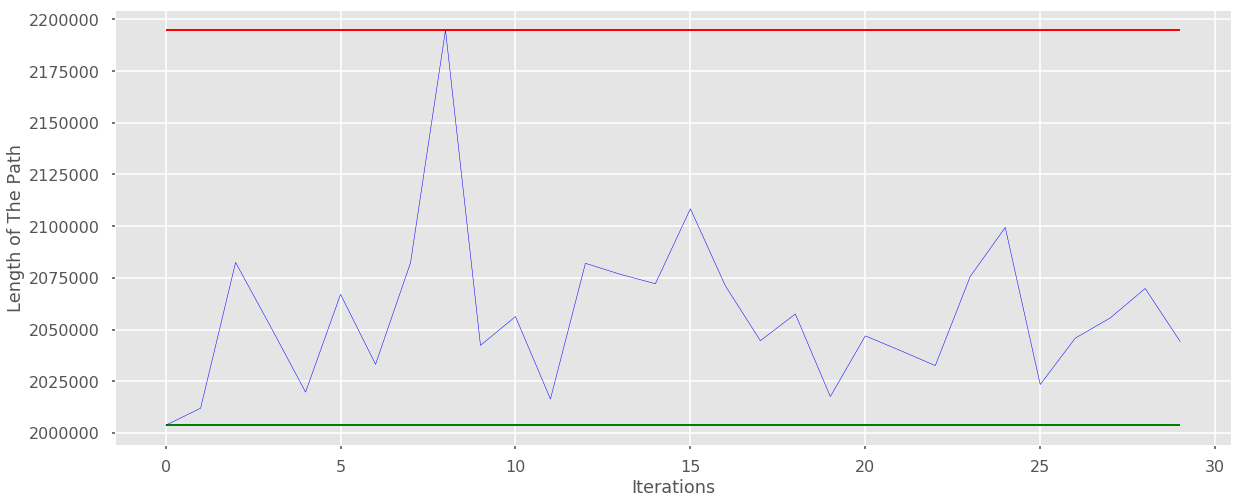

In [16]:
# the following plot shows length of path of each iteration run. 

all_distances = route.drop_duplicates('iteration').sort_values(by='iteration')['distance'].values
random_routes = route.sort_values(by='distance', ascending=False)['iteration'].unique()[:5]
shortest_route = shortest_route.loc[: , ['visitOrder', 'lng', 'lat']]
shortest_route.rename(columns={'visitOrder': 'order'}, inplace=True)

f, ax = plt.subplots(1, 1, figsize=(20,8))
ax.plot([_ for _ in all_distances], color='blue', linewidth=0.5)
ax.hlines(y=min([_ for _ in all_distances]), xmin=0, xmax=n-1, color='green', linewidth=2)
ax.hlines(y=max([_ for _ in all_distances]), xmin=0, xmax=n-1, color='red', linewidth=2)
ax.set_xlabel('Iterations')
ax.set_ylabel('Length of The Path');

print(f"[Min] {min([_ for _ in all_distances])};  [Max] {max([_ for _ in all_distances])}")

In [17]:
sa_shortest_route = pd.DataFrame([LineString((shortest_route.values[i-1][1:][::-1], 
                                              shortest_route.values[i][1:][::-1])) 
                                  for i in range(1, len(shortest_route.values))], columns=['geometry'])
sa_shortest_route = sa_shortest_route.append(pd.DataFrame([LineString((shortest_route.values[-1][1:][::-1], shortest_route.values[0][1:][::-1]))], columns=['geometry']))
sa_shortest_route['order'] = sa_shortest_route.index + 1

sa_shortest_route_origin = pd.DataFrame([Point(shortest_route.values[i-1][1:][::-1]) 
                                  for i in range(1, len(shortest_route.values))], columns=['geometry'])
sa_shortest_route_origin = sa_shortest_route_origin.append(pd.DataFrame([Point(shortest_route.values[-1][1:][::-1])], columns=['geometry']))
sa_shortest_route_origin['order'] = sa_shortest_route_origin.index + 1

sa_shortest_route_dst = pd.DataFrame([Point(shortest_route.values[i][1:][::-1]) 
                                  for i in range(1, len(shortest_route.values))], columns=['geometry'])
sa_shortest_route_dst = sa_shortest_route_dst.append(pd.DataFrame([Point(shortest_route.values[0][1:][::-1])], columns=['geometry']))
sa_shortest_route_dst['order'] = sa_shortest_route_dst.index + 1

Map(layers=[
    Layer(sa_shortest_route_origin,
          geom_col = 'geometry',
          style = animation_style('order', size = 10, color = '#882255', opacity = 1, duration=40, fade_in = 0, fade_out = 0.5)),
    Layer(sa_shortest_route_dst,
         geom_col = 'geometry',
         style = animation_style('order', size = 10, color = '#88CCEE', opacity = 1, duration=40, fade_in = 0, fade_out = 0.5)),
    Layer(sa_shortest_route, 
          geom_col = 'geometry',
          style = animation_style('order', size = 3, color = 'red', opacity = 1, duration=40, fade_in = 0, fade_out = 'hold'))
    ],
    basemap = basemaps.voyager)

<br/>

### Method 3: **Ant Colony Optimization**

In [18]:
# alpha: relative importance of pheromone
# beta: relative importance of heuristic information
# rho: pheromone residual coefficient
# q: pheromone intensity
# strategy: pheromone update strategy. 0 - ant-cycle, 1 - ant-quality, 2 - ant-density

aco = ACO(ant_count=200, generations=100, alpha=1.0, beta=10.0, rho=0.75, q=10, strategy=3)

cost_matrix = distance_aco(latlng_dict)
rank = len(latlng_dict)
graph = Graph(cost_matrix, rank)
path, cost = aco.solve(graph)

[Done] Create A Distance Matrix For ACO
[Done] Load the Graph
[Generation #0] [best cost: 2234235.5580633623]
[Generation #1] [best cost: 2183767.4334174558]
[Generation #2] [best cost: 2110474.37924279]
[Generation #3] [best cost: 2110474.37924279]
[Generation #4] [best cost: 2110474.37924279]
[Generation #5] [best cost: 2110474.37924279]
[Generation #6] [best cost: 2110338.719332124]
[Generation #7] [best cost: 2110338.719332124]
[Generation #8] [best cost: 2094344.5599303502]
[Generation #9] [best cost: 2094344.5599303502]
[Generation #10] [best cost: 2094344.5599303502]
[Generation #11] [best cost: 2094344.5599303502]
[Generation #12] [best cost: 2086838.342287729]
[Generation #13] [best cost: 2086838.342287729]
[Generation #14] [best cost: 2086838.342287729]
[Generation #15] [best cost: 2086838.342287729]
[Generation #16] [best cost: 2086838.342287729]
[Generation #17] [best cost: 2086838.342287729]
[Generation #18] [best cost: 2086838.342287729]
[Generation #19] [best cost: 20868

In [19]:
print(f'[Done] Cost: {cost}\nPath: {path}')

[Done] Cost: 2086838.342287729
Path: [11, 36, 3, 18, 58, 63, 39, 25, 5, 64, 52, 24, 2, 45, 14, 47, 43, 28, 0, 60, 44, 62, 19, 4, 22, 20, 65, 31, 51, 46, 33, 34, 50, 35, 30, 13, 69, 12, 9, 21, 37, 53, 38, 17, 48, 42, 23, 61, 72, 15, 8, 10, 41, 16, 29, 32, 40, 68, 27, 26, 71, 56, 70, 67, 49, 54, 55, 66, 57, 6, 59, 1, 7]


In [20]:
loop = path.copy()
loop.append(loop[0])

ac_shortest_route = pd.DataFrame([LineString((lnglat[loop[i-1]], lnglat[loop[i]])) for i in range(1, len(loop))], columns=['geometry'])
ac_shortest_route['order'] = ac_shortest_route.index + 1
ac_shortest_route_origin = pd.DataFrame([Point(lnglat[loop[i-1]]) for i in range(1, len(loop))], columns=['geometry'])
ac_shortest_route_origin['order'] = ac_shortest_route_origin.index + 1
ac_shortest_route_dst = pd.DataFrame([Point(lnglat[loop[i]]) for i in range(1, len(loop))], columns=['geometry'])
ac_shortest_route_dst['order'] = ac_shortest_route_dst.index + 1

Map(layers=[
    Layer(ac_shortest_route_origin,
          geom_col = 'geometry',
          style = animation_style('order', size = 10, color = '#882255', opacity = 1, duration=40, fade_in = 0, fade_out = 0.5)),
    Layer(ac_shortest_route_dst,
         geom_col = 'geometry',
         style = animation_style('order', size = 10, color = '#88CCEE', opacity = 1, duration=40, fade_in = 0, fade_out = 0.5)),
    Layer(ac_shortest_route, 
          geom_col = 'geometry',
          style = animation_style('order', size = 3, color = 'red', opacity = 1, duration=40, fade_in = 0, fade_out = 'hold'))
    ],
    basemap = basemaps.voyager)

## **Reference**

- Simulated Annealing: https://github.com/perrygeo/simanneal
- Ant Colony Optimization: https://github.com/ppoffice/ant-colony-tsp
- Christofides Algorithm: https://github.com/Retsediv/ChristofidesAlgorithm